In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T

#### Estimating the speed of light

In [3]:
measurements = np.array([ 28,  26,  33,  24,  34, -44,  27,  16,  40,  -2,  29,  22,  24,
        21,  25,  30,  23,  29,  31,  19,  24,  20,  36,  32,  36,  28,
        25,  21,  28,  29,  37,  25,  28,  26,  30,  32,  36,  26,  30,
        22,  36,  23,  27,  27,  28,  27,  31,  27,  26,  33,  26,  32,
        32,  24,  39,  28,  24,  25,  32,  25,  29,  27,  28,  29,  16,
        23])

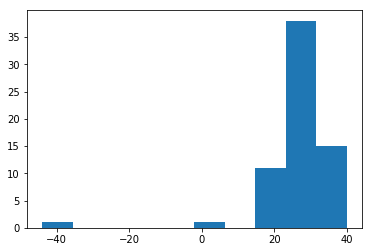

In [4]:
plt.hist(measurements);

In [5]:
np.mean(measurements)

26.21212121212121

In [6]:
np.std(measurements)

10.663610099255504

We specify here the noninformative prior: <br>
p($\mu$, $\sigma^{2}$) $\propto$ $(\sigma^{2})^{-1}$

In pymc3, we need provide log of it to write our custom distribution.

In [7]:
with pm.Model() as model_speed_of_light:
    theta = pm.DensityDist(
        'mu_sigma2', 
        lambda value: -2*T.log(value[1]),
        shape=2,
        testval=[30, 1] # mu doesn't matter (doesn't influence prior)
    )
    y = pm.Normal('y', mu=theta[0], tau=1/theta[1], observed=measurements)
    trace = pm.sample(1000)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_sigma2]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 4330.97draws/s]


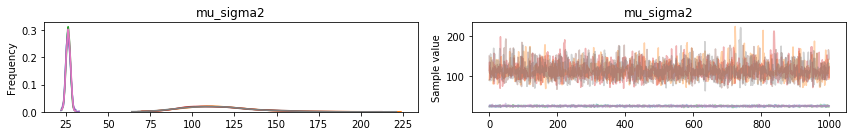

In [8]:
pm.traceplot(trace);

In [9]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu_sigma2__0,26.206309,1.307265,0.023251,23.677060,28.701532,2899.943529,0.999810
mu_sigma2__1,114.893113,20.769075,0.389902,77.573743,155.610760,2831.160767,1.000054


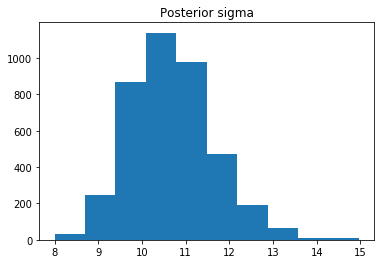

In [10]:
plt.hist(np.sqrt(trace['mu_sigma2'][:, 1]));
plt.title('Posterior sigma');

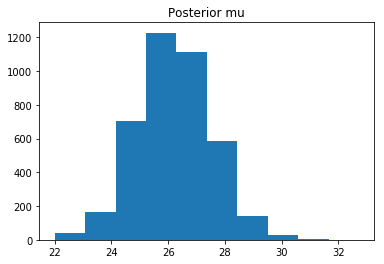

In [11]:
plt.hist(trace['mu_sigma2'][:, 0]);
plt.title('Posterior mu');

#### Normal data with a conjugate prior distribution (2-parameter model)

Taking noninformative prior: <br>
p($\mu$, $\sigma^{2}$) $\propto$ $(\sigma^{2})^{-1}$

We can compute posterior: <br>
p($\mu$, $\sigma^{2}$|y) $\propto$ p($\mu$, $\sigma^{2}$)$\prod_{i=1}^{i=n}$p($y_{i}$|$\mu$, $\sigma^{2}$) = $(\sigma^{2})^{-1}$ $(\frac{1}{\sqrt{2\pi\sigma^{2}}})^{n}$$e^{-\frac{1}{2\sigma^{2}}\sum_{i=1}^{n}(y_{i} - \mu)^{2}}$ $\propto$ $\sigma^{-n-2}$$e^{-\frac{1}{2\sigma^{2}}\sum_{i=1}^{n}(y_{i} - \mu)^{2}}$

To compute p($\mu$|$\sigma^{2}$, y) we can use the result from the previous chapter (posterior of mean given known variance). As a reminder:

$\mu$|y $\sim$ N($\mu_{post}$, $\tau_{post}^{2}$), where <br>

$\mu_{1}$ = $\frac{\frac{1}{\tau_{0}^{2}}\mu_{0} + \frac{n}{\sigma^{2}}\bar{y}}{\frac{1}{\tau_{0}^{2}} + \frac{n}{\sigma^{2}}}$

$\mu_{0}$, $\tau_{0}^{2}$ are mean and variance that specify prior on $\mu$. In our setting (uniform prior) variance is infinite, which gives: <br>
$\mu_{post}$ = $\bar{y}$ and, <br>
$\tau_{post}^{2}$ = $\frac{\sigma^{2}}{n}$ (as $\frac{1}{\tau_{post}^{2}}$ = $\frac{1}{\tau_{0}^{2}}$ + $\frac{n}{\sigma^{2}}$), so <br><br>
p($\mu$|$\sigma^{2}$, y) $\sim$ N($\bar{y}$, $\frac{\sigma^{2}}{n}$)

To obtain p($\sigma^{2}$|y), one has to integrate out $\mu$ from p($\mu$, $\sigma^{2}$|y). After tedious algebra, we get <br>
p($\sigma^{2}$|y) $\propto$ Inv-${\chi^{2}}$(n - 1, $s^{2}$), where $s^{2}$ = $\frac{1}{n-1}\sum_{i=1}^{n}(y_{i} - \bar{y})^{2}$

Now, we see how to specify a prior distribution to get a conjugate prior (replacing noninformative prior). The conjugate prior must have the product form: <br><br>
p($\mu$, $\sigma^{2}$) = p($\sigma^{2}$)p($\mu$|$\sigma^{2}$). A convienient parametrization is given by the following specification: <br><br>
$\mu$|$\sigma$ $\sim$ N($\mu_{0}$, $\sigma^{2}/\kappa_{0}$) <br>
$\sigma^{2}$ $\sim$ 
Inv-${\chi^{2}}$($\nu_{0}$, $\sigma_{0}^{2}$)

In [12]:
mu_0 = 25
nu_0 = 1
sigma_0 = 25
alpha = nu_0/2
beta = alpha * sigma_0

with pm.Model() as model_speed_of_light2:
    sigma2 = pm.InverseGamma('sigma2', alpha=alpha, beta=beta)
    mu = pm.Normal('mu', mu=25, tau=1/sigma2)
    y = pm.Normal('y', mu=mu, tau=1/sigma2, observed=measurements)
    trace = pm.sample(1000)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma2]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 4240.72draws/s]


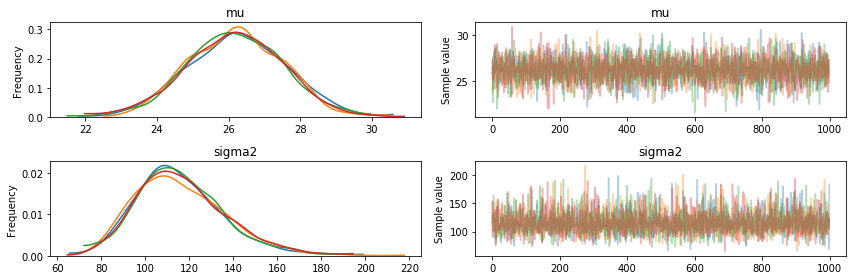

In [13]:
pm.traceplot(trace);

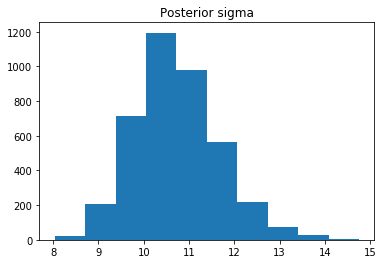

In [14]:
plt.hist(np.sqrt(trace['sigma2']));
plt.title('Posterior sigma');

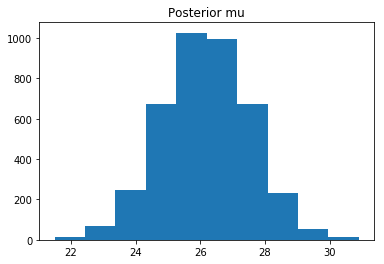

In [15]:
plt.hist(trace['mu']);
plt.title('Posterior mu');

#### Multinomial model for categorical data 

Likelihood model: <br><br>
p(y|$\theta$) $\propto$ $\prod_{j=1}^{k}\theta_{j}^{y_{j}}$, where $\sum_{j=1}^{k}\theta_{j}$=1. 

The conjugate prior distribution is a multivariate generalization of the beta distribution known as the Dirichlet, <br><br>
p($\theta$, $\alpha$) $\propto$ $\prod_{j=1}^{k}$$\theta_{j}^{\alpha_{j}-1}$

In [16]:
y = np.array([727, 583, 137])
with pm.Model() as model:
    theta = pm.Dirichlet('theta', a=np.ones_like(y))
    output = pm.Multinomial('output', n=np.sum(y), p=theta, observed=y)
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:02<00:00, 2950.57draws/s]


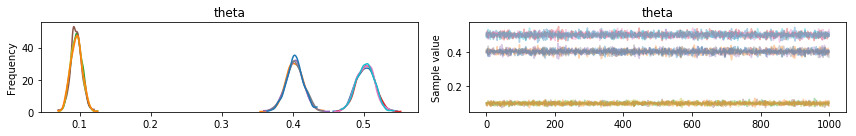

In [17]:
pm.traceplot(trace);

In [18]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta__0,0.502195,0.012934,0.000200,0.477645,0.527893,3813.919019,1.000103
theta__1,0.402542,0.012512,0.000193,0.378077,0.427261,3974.890025,0.999886
theta__2,0.095263,0.007871,0.000115,0.080180,0.110462,4001.411444,1.000071


In [19]:
trace.get_values('theta')

array([[0.51283974, 0.40182285, 0.0853374 ],
       [0.48425245, 0.41673751, 0.09901004],
       [0.49313555, 0.4116463 , 0.09521814],
       ...,
       [0.51074878, 0.39995102, 0.0893002 ],
       [0.49330412, 0.39618189, 0.110514  ],
       [0.5100475 , 0.41129851, 0.07865399]])

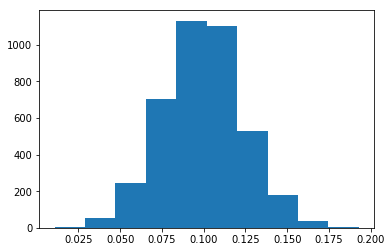

In [20]:
plt.hist(trace.get_values('theta')[:, 0] -
        trace.get_values('theta')[:, 1]);

#### 3.12

In [21]:
df = pd.DataFrame({
    'year': list(range(1976, 1986)),
    'fatal_accidents': [24, 25, 31, 31, 22, 21, 26, 20, 16, 22],
    'passenger_deaths': [734, 516, 754, 877, 814, 362, 764, 809, 223, 1066],
    'death_rate': [0.19, 0.12, 0.15, 0.16, 0.14, 0.06, 0.13, 0.13, 0.03, 0.15]
})
df

,death_rate,fatal_accidents,passenger_deaths,year
0,0.19,24,734,1976
1,0.12,25,516,1977
2,0.15,31,754,1978
3,0.16,31,877,1979
4,0.14,22,814,1980
5,0.06,21,362,1981
6,0.13,26,764,1982
7,0.13,20,809,1983
8,0.03,16,223,1984
9,0.15,22,1066,1985


In [22]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=25, sd=10)
    beta = pm.Uniform('beta', lower=-0.01, upper=0.01)
    ratio = alpha + beta * df['year'].values 
    y = pm.Poisson('y', mu=ratio, observed=df['fatal_accidents'].values)
    trace = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:06<00:00, 1845.61draws/s]
The acceptance probability does not match the target. It is 0.8974291807654454, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


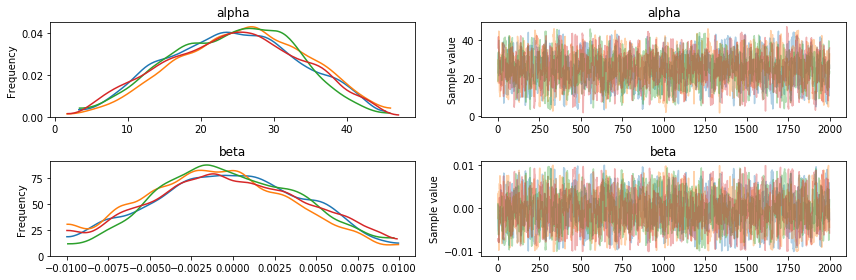

In [23]:
pm.traceplot(trace);

In [24]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,24.692132,8.846818,0.214759,8.069294,41.373694,1526.321870,1.002518
beta,-0.000415,0.004496,0.000110,-0.008741,0.008187,1513.549693,1.002726


In [25]:
yp = trace['alpha'] + trace['beta'] * 1986

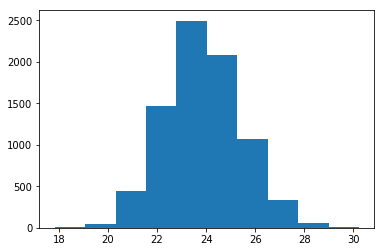

In [26]:
plt.hist(yp);

In [27]:
np.percentile(yp, [5, 95])

array([21.36587233, 26.49066265])